# Review output from MAAP DPS for ABoVE Boreal Biomass Project: Summer 2022 update
* Boreal biomass cloud-optimized geotiff (COG) tiles are brought together in a MosaicJSON file that is mapped with Folium
* to update the AGB tindex master csv and its corresponding MosaicJson, run _build_mosaic_json.ipynb_

Paul Montesano, Laura Duncanson (PI), Nathan Thomas

Update: using TiTiler and ipyleaflet following MAAP tutorials

In [1]:
#%pip install cogeo_mosaic --quiet
%pip install rio-cogeo
%pip uninstall stac_ipyleaflet -y

%pip install git+https://github.com/MAAP-Project/stac_ipyleaflet.git@312f14695f799324e52f8d6b20f896f015665ad2#egg-info=stac_ipyleaflet


#to install cogeo-mosaic from source in terminal
#python -m pip install git+http://github.com/developmentseed/cogeo-mosaic

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/MAAP-Project/stac_ipyleaflet.git (to revision 312f14695f799324e52f8d6b20f896f015665ad2) to /tmp/pip-req-build-98g668qd
  Running command git clone --filter=blob:none --quiet https://github.com/MAAP-Project/stac_ipyleaflet.git /tmp/pip-req-build-98g668qd
  Running command git rev-parse -q --verify 'sha^312f14695f799324e52f8d6b20f896f015665ad2'
  Running command git fetch -q https://github.com/MAAP-Project/stac_ipyleaflet.git 312f14695f799324e52f8d6b20f896f015665ad2
  Running command git checkout -q 312f14695f799324e52f8d6b20f896f015665ad2
  Resolved https://github.com/MAAP-Project/stac_ipyleaflet.git to commit 312f14695f799324e52f8d6b20f896f015665ad2
  Preparing metadata (setup.py) ... done
  Using cached ipyevents-2.0.2-py3-none-any.whl.metadata (2.9 kB)
  Using cached python_dotenv-1.0.1-py3-none-any.whl.metadata (23 kB)
Using

In [2]:
import os

titiler_url = "https://titiler.maap-project.org"
min_zoom = 0
max_zoom = 0
band_min = 0
band_max = 4000
user = os.getenv('CHE_WORKSPACE_NAMESPACE')
bucket = "maap-ops-workspace"
color_map = "gist_earth_r"

In [3]:
def checkFilePath(file_path):
    result = s3.list_objects(Bucket=bucket, Prefix=file_path)
    exists = True if 'Contents' in result else False
    if exists:
        print('PATH EXISTS')
        return [i for i in result['Contents'] if i["Key"].endswith('.tif')]
    return exists

In [4]:
import boto3
import pandas as pd

#using the desired tindex to get files of interest
tindex = 's3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/BOREAL_MAP/boreal_agb_2023_v3/AGB_H30_2020/local_training_full/AGB_tindex_master.csv'
files = pd.read_csv(tindex)['s3_path']

#subset files
#files=files[0:500]
print(files)

0       s3://maap-ops-workspace/lduncanson/dps_output/...
1       s3://maap-ops-workspace/lduncanson/dps_output/...
2       s3://maap-ops-workspace/lduncanson/dps_output/...
3       s3://maap-ops-workspace/lduncanson/dps_output/...
4       s3://maap-ops-workspace/lduncanson/dps_output/...
                              ...                        
4876    s3://maap-ops-workspace/lduncanson/dps_output/...
4877    s3://maap-ops-workspace/lduncanson/dps_output/...
4878    s3://maap-ops-workspace/lduncanson/dps_output/...
4879    s3://maap-ops-workspace/lduncanson/dps_output/...
4880    s3://maap-ops-workspace/lduncanson/dps_output/...
Name: s3_path, Length: 4881, dtype: object


In [5]:
files[0]

's3://maap-ops-workspace/lduncanson/dps_output/run_boreal_biomass_map/boreal_agb_2023_v3/AGB_H30_2020/local_training_full/2023/12/07/13/35/47/703576/boreal_agb_202312071701984853_2618.tif'

## Get raster info (bounds, zoom, data type) from first file in array of files


In [6]:
import httpx

url = files[0]

r = httpx.get(
    f"{titiler_url}/cog/info",
    params = {
        "url": url,
    }
).json()

if r.get('count') > 0:
    bounds = r.get("bounds")
    min_zoom = r.get("minzoom")
    max_zoom = r.get("maxzoom")
    zoom = min_zoom + 1 if min_zoom == 0 else min_zoom
    bands = r.get("band_metadata")

    print("Bounds:", bounds)
    print("Zoom:", zoom, "min =", min_zoom, "max =", max_zoom)
    print("Data type:", r.get("dtype"))
    print("Bands:", bands)

Bounds: [-102.26365907134746, 48.28803685677814, -100.66114880020578, 49.35235356038255]
Zoom: 8 min = 8 max = 12
Data type: float32
Bands: [['b1', {'STATISTICS_MAXIMUM': '68.659515380859', 'STATISTICS_MEAN': '-9999', 'STATISTICS_MINIMUM': '1.93840944767', 'STATISTICS_STDDEV': '-9999'}], ['b2', {'STATISTICS_MAXIMUM': 'nan', 'STATISTICS_MEAN': '-9999', 'STATISTICS_MINIMUM': 'nan', 'STATISTICS_STDDEV': '-9999'}]]


## Create mosaic from file urls


In [10]:
from cogeo_mosaic.mosaic import MosaicJSON

if min_zoom == 0 and max_zoom == 0:
    print("Warning: missing zoom attributes!")

mosaicdata = MosaicJSON.from_urls(files, minzoom=min_zoom, maxzoom=max_zoom, quadkey_zoom=7)
print("Mosaic created!")

Mosaic created!


## Upload the mosaicjson to the TiTiler and filter for tilejson results

In [8]:
mosaic_links = httpx.post(
    url=f"{titiler_url}/mosaics",
    headers={
        "Content-Type": "application/vnd.titiler.mosaicjson+json",
    },
    json=mosaicdata.model_dump(exclude_none=True),
).json()
# print(mosaic_links)

NameError: name 'mosaicdata' is not defined

In [9]:
tilejson_object = list(
    filter(lambda x: x.get("rel") == "tilejson", dict(mosaic_links)["links"])
)
tilejson_url = tilejson_object[0]["href"]
tilejson_url

NameError: name 'mosaic_links' is not defined

## Calculate raster center for map placement

In [24]:
r = httpx.get(tilejson_url).json()
center_data = r.get('center')
center = (center_data[1], center_data[0])
zoom = center_data[2]
print("Zoom:", zoom)

Zoom: 7


In [25]:
from shapely.geometry import box

polygon = box(*bounds)
center = (polygon.centroid.y, polygon.centroid.x)
print("Center:", center)

Center: (62.077605797962505, 118.66606158844183)


## Create the TileLayer

In [26]:
from ipyleaflet import TileLayer

params = {
    "return_mask": "true",
    "rescale": f"{0}, {150}",
    "bidx": "1",
    "colormap_name": "viridis"
}

r = httpx.get(tilejson_url, params=params).json()

layer_url = r['tiles'][0]
custom_layer = TileLayer(url=layer_url, show_loading=True, transparent=True)

In [27]:
import os
os.environ['TITILER_STAC_ENDPOINT']='https://titiler-stac.maap-project.org'
os.environ['TITILER_ENDPOINT']='https://titiler.maap-project.org'
os.environ['STAC_CATALOG_NAME']='https://stac.maap-project.org'
os.environ['STAC_CATALOG_URL']='https://stac-browser.maap-project.org/external/'

In [28]:
%env TITILER_STAC_ENDPOINT=https://titiler-stac.maap-project.org
%env TITILER_ENDPOINT=https://titiler.maap-project.org
%env STAC_CATALOG_NAME=MAAP STAC
%env STAC_CATALOG_URL=https://stac.maap-project.org
%env STAC_BROWSER_URL=https://stac-browser.maap-project.org/external/

env: TITILER_STAC_ENDPOINT=https://titiler-stac.maap-project.org
env: TITILER_ENDPOINT=https://titiler.maap-project.org
env: STAC_CATALOG_NAME=MAAP STAC
env: STAC_CATALOG_URL=https://stac.maap-project.org
env: STAC_BROWSER_URL=https://stac-browser.maap-project.org/external/


## Add the mosaic tile layer to the map

In [21]:
%pip uninstall stac_ipyleaflet -y
%pip install git+https://github.com/MAAP-Project/stac_ipyleaflet.git@312f14695f799324e52f8d6b20f896f015665ad2#egg-info=stac_ipyleaflet


Found existing installation: stac-ipyleaflet 0.3.5
Uninstalling stac-ipyleaflet-0.3.5:
  Successfully uninstalled stac-ipyleaflet-0.3.5
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/MAAP-Project/stac_ipyleaflet.git (to revision 312f14695f799324e52f8d6b20f896f015665ad2) to /tmp/pip-req-build-3jw8itb3
  Running command git clone --filter=blob:none --quiet https://github.com/MAAP-Project/stac_ipyleaflet.git /tmp/pip-req-build-3jw8itb3
  Running command git rev-parse -q --verify 'sha^312f14695f799324e52f8d6b20f896f015665ad2'
  Running command git fetch -q https://github.com/MAAP-Project/stac_ipyleaflet.git 312f14695f799324e52f8d6b20f896f015665ad2
  Running command git checkout -q 312f14695f799324e52f8d6b20f896f015665ad2
  Resolved https://github.com/MAAP-Project/stac_ipyleaflet.git to commit 312f14695f799324e52f8d6b20f896f015665ad2
  Preparing metadata (setup.py) ... done
  Created wheel for stac-ipyleaflet: filename=stac_ipyleaflet-0.3.5-py

In [29]:
import stac_ipyleaflet
#zoom=6
#center=[67.7948320856971, 29.169124818791225]
m = stac_ipyleaflet.StacIpyleaflet(zoom=zoom, center=center)
m.add_layer(custom_layer)
m

Output()

Output()

StacIpyleaflet(center=[62.077605797962505, 118.66606158844183], controls=(ZoomControl(options=['position', 'zo…

In [15]:
import os 
os.environ['TITILER_STAC_ENDPOINT']='https://titiler.maap-project.org'
os.environ['TITILER_ENDPOINT']='https://titiler.maap-project.org'
#os.environ['STAC_CATALOG_NAME']='REPLACE_WITH_NAME_OF_STAC_CATALOG'
#os.environ['STAC_CATALOG_URL']='REPLACE_WITH_URL_OF_STAC_CATALOG'

## Attention: adjust path
##### Path to your icesat2_boreal/lib dir - clone the icesat2_boreal GitHub repository
https://github.com/lauraduncanson/icesat2_boreal.git

In [19]:
ICESAT2_BOREAL_REPO_PATH = '/projects/icesat2_boreal' # /projects/Developer/icesat2_boreal/lib
ICESAT2_BOREAL_LIB_PATH = ICESAT2_BOREAL_REPO_PATH + '/lib'

In [2]:
# For some reason this is needed to get s3fs to work in ExtractUtils
# this upgrades to 0.3.4 even though we already specify this version in requirements_main...
!pip install s3fs --upgrade

  Using cached s3fs-2023.1.0-py3-none-any.whl (27 kB)
  Using cached aiobotocore-2.4.2-py3-none-any.whl (66 kB)
  Using cached botocore-1.27.59-py3-none-any.whl (9.1 MB)
  Attempting uninstall: botocore
    Found existing installation: botocore 1.20.72
    Uninstalling botocore-1.20.72:
      Successfully uninstalled botocore-1.20.72
  Attempting uninstall: s3fs
    Found existing installation: s3fs 0.3.4
    Uninstalling s3fs-0.3.4:
      Successfully uninstalled s3fs-0.3.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
boto3 1.17.72 requires botocore<1.21.0,>=1.20.72, but you have botocore 1.27.59 which is incompatible.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [20]:
try:
    import geopandas as gpd
except ModuleNotFoundError:
    print('Need to pip install packages...')
    !pip install -U -r $ICESAT2_BOREAL_REPO_PATH/dps/requirements_main.txt
    
import geopandas
import pandas as pd
import os
import json
import collections
import numpy as np
import sys
import s3fs
import matplotlib.pyplot as plt
sys.path.append(ICESAT2_BOREAL_LIB_PATH)
sys.path.append('/projects/Developer/icesat2_boreal/lib')
import maplib_folium
import ExtractUtils
from folium import TileLayer
print("Importing packages complete.")

INFO:botocore.credentials:Found credentials from IAM Role: MAAP-ADE-K8S


Importing packages complete.


## Set up paths to MosaicJson files needed to map output

In [28]:
AGB_prelim_tindex_master_fn = 's3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/AGB_tindex_master.csv'
AGB_prelim_mosaic_json_fn = 's3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/AGB_tindex_master_mosaic.json'

AGB_v2_tindex_master_fn = 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/v2/AGB_tindex_master.csv'  # <-- 07 indicates the summer update
AGB_v2_mosaic_json_fn   = 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/v2/AGB_tindex_master_mosaic.json'

AGB_spring2022_tindex_master_fn = 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/06/AGB_tindex_master.csv'  # <-- 07 indicates the summer update
AGB_spring2022_mosaic_json_fn   = 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/06/AGB_tindex_master_mosaic.json'

AGB_summer2022_tindex_master_fn = 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/07/AGB_tindex_master.csv'  # <-- 07 indicates the summer update
AGB_summer2022_mosaic_json_fn   = 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/07/AGB_tindex_master_mosaic.json'

AGB_fall2022_tindex_master_fn = 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/AGB/fall2022/map_boreal_2022_v3/11/AGB_tindex_master.csv'
AGB_fall2022_mosaic_json_fn = 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/AGB/fall2022/map_boreal_2022_v3/11/AGB_tindex_master_mosaic.json'

AGB_fall2022_noground_tindex_master_fn = 's3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/AGB/2023/AGB_tindex_master.csv'
AGB_fall2022_noground_mosaic_json_fn = 's3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/AGB/2023/AGB_tindex_master_mosaic.json'

AGB_fall2023_master_fn = 's3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/BOREAL_MAP/boreal_agb_2023_v2/AGB_H30_2020/norway_val_loc_training_perc50/AGB_tindex_master_mosaic.json'
AGB_fall2023_local_master_fn = 's3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/BOREAL_MAP/boreal_agb_2023_v2/AGB_H30_2020/norway_val/AGB_tindex_master_mosaic.json'

#HLS_tindex_master_fn = 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/HLS_test_redo/spring2022/HLS_tindex_master.csv'
#HLS_mosaic_json_fn   = 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/HLS_test_redo/spring2022/HLS_tindex_master_mosaic.json'

#HLS_tindex_c2020_master_fn = f's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/HLS/fall2022/HLS_stack_2022_v2/HLS_tindex_master.csv'
#HLS_mosaic_c2020_json_fn   = f's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/HLS/fall2022/HLS_stack_2022_v2/HLS_tindex_master_mosaic.json'

# Final HLS comp for c2020
HLS_tindex_c2020_master_fn = f's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/HLS/c2020/HLS_stack_2022_v2/HLS_tindex_mastercsv'
HLS_mosaic_c2020_json_fn = f's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/HLS/c2020/HLS_stack_2022_v2/HLS_tindex_master_mosaic.json'

Topo_tindex_master_fn  = 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/Topo_tindex_master.csv'
Topo_mosaic_json_fn  = 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/Topo_tindex_master_mosaic.json'

#ATL08_filt_tindex_master_fn = 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/ATL08_filt_tindex_master.csv'
ATL08_filt_tindex_master_fn = 's3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/fall2022/ATL08_filt_tindex_master.csv'
#ATL08_filt_tindex_json_fn= "/projects/my-public-bucket/DPS_tile_lists/ATL08_filt_tindex_master.json"

#LC_mosaic_json_fn = 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/09/LC_tindex_master_mosaic.json'

# Final LC mosaic for c2020
LC_mosaic_json_fn = 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/LC/LC_tindex_master_mosaic.json'

boreal_tile_index_path = '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg' 

INFO:botocore.credentials:Found credentials from IAM Role: MAAP-ADE-K8S
/projects/icesat2_boreal/lib/ExtractUtils.py:556: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres") )


Building s3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/BOREAL_MAP/boreal_agb_2023_v2/AGB_H30_2020/norway_val/AGB_tindex_master_mosaic.json


INFO:botocore.credentials:Found credentials from IAM Role: MAAP-ADE-K8S
INFO:botocore.credentials:Found credentials from IAM Role: MAAP-ADE-K8S
/projects/icesat2_boreal/lib/ExtractUtils.py:556: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres") )


Building s3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/BOREAL_MAP/boreal_agb_2023_v2/AGB_H30_2020/norway_val_loc_training_perc50/AGB_tindex_master_mosaic.json


INFO:botocore.credentials:Found credentials from IAM Role: MAAP-ADE-K8S


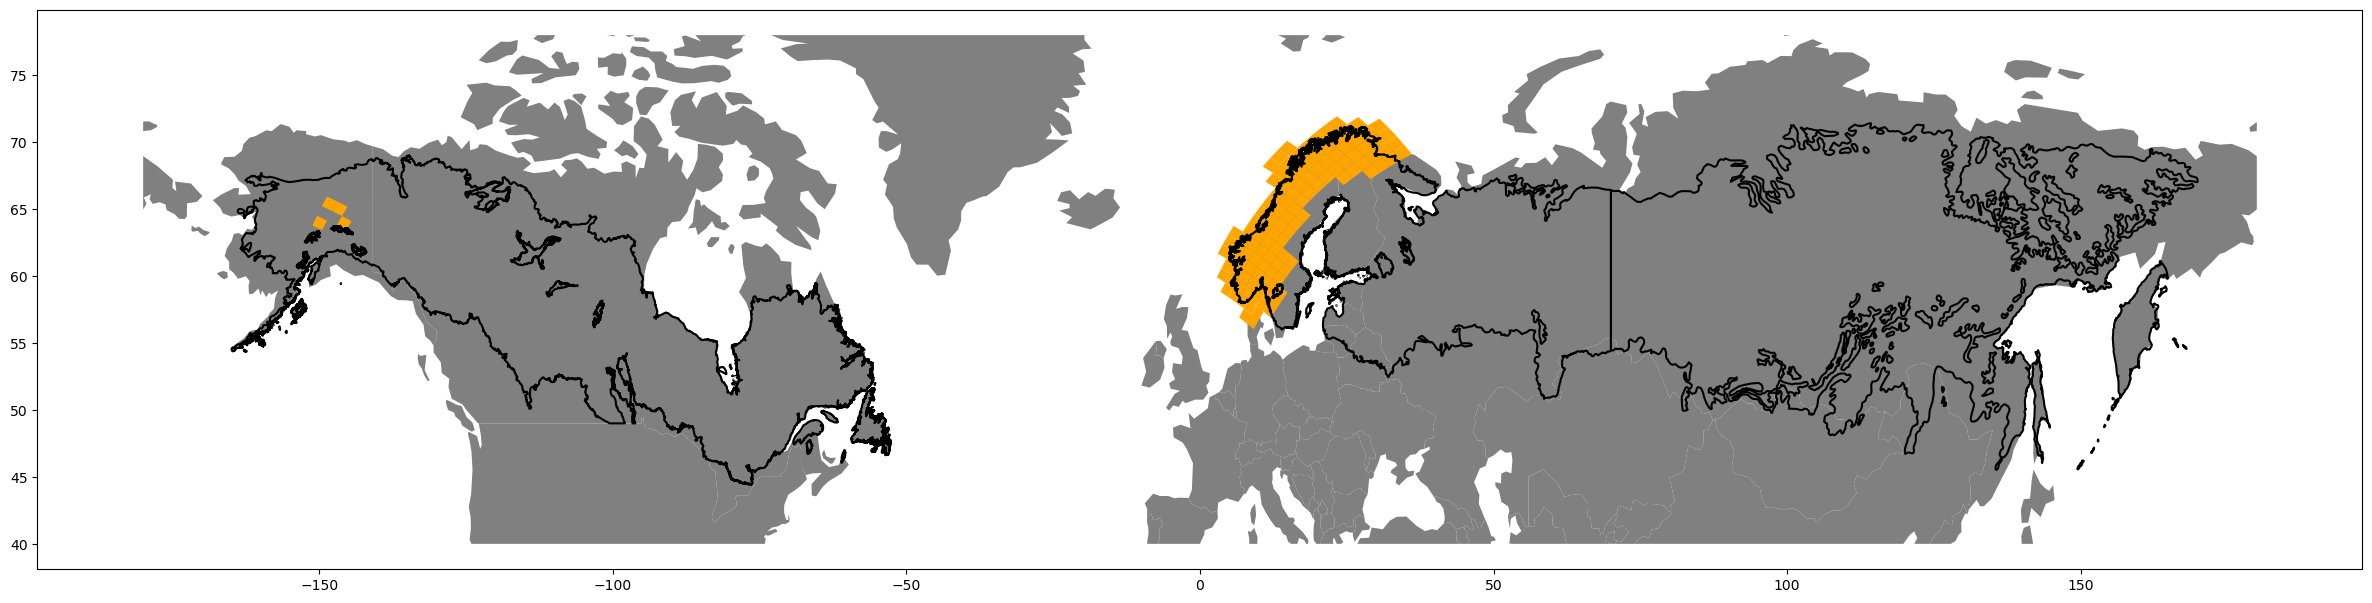

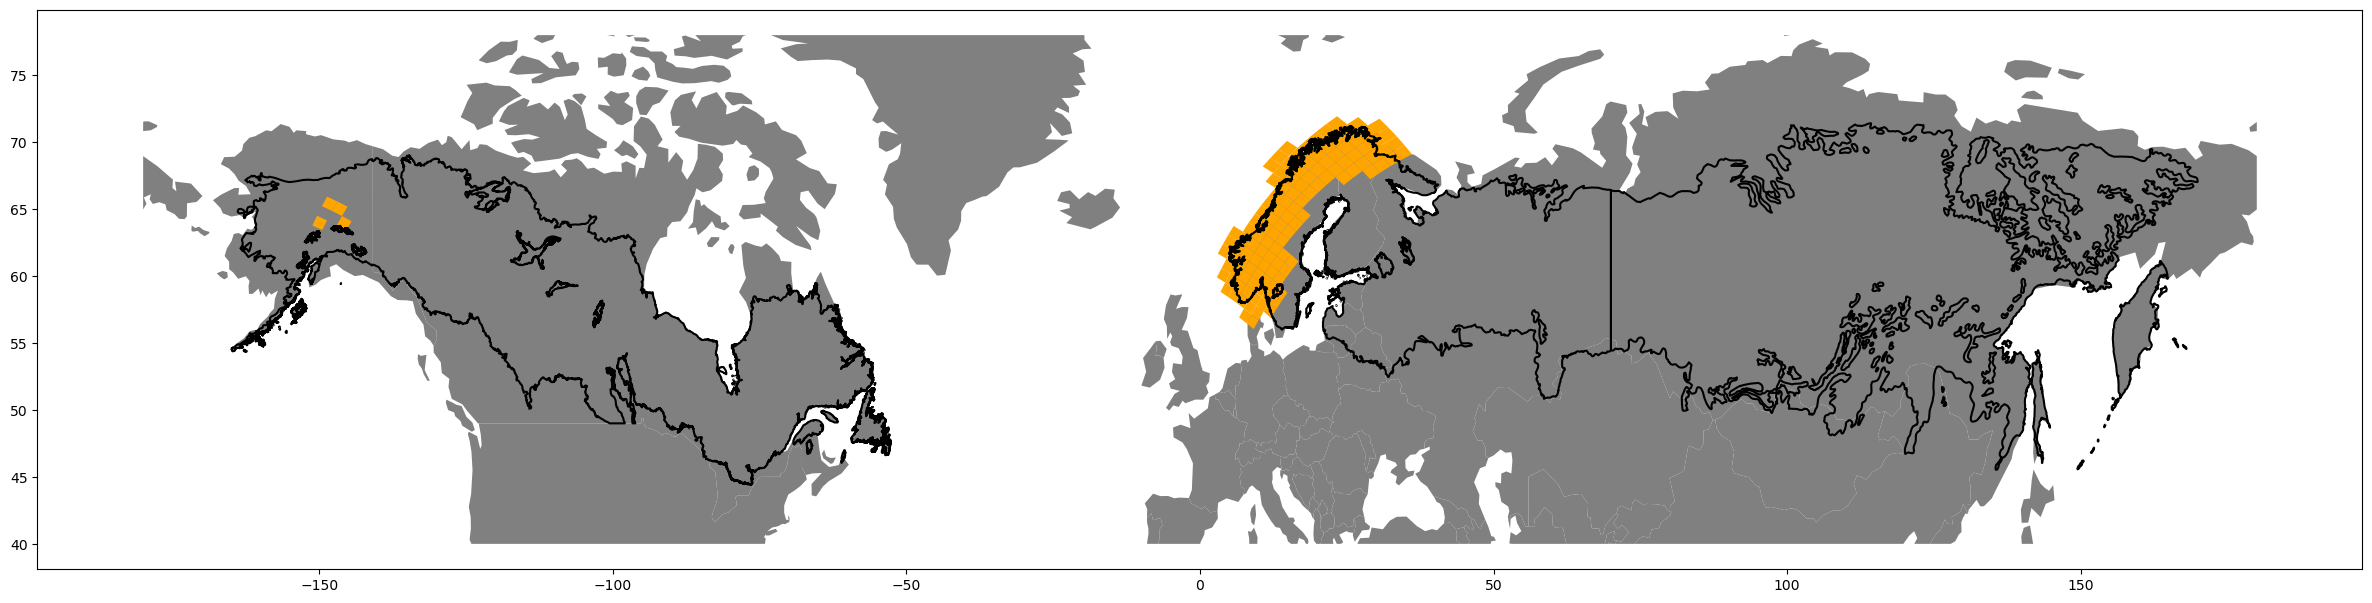

In [22]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [30, 10]
import importlib
import ExtractUtils
importlib.reload(ExtractUtils)

Ht_fall2022_noground_tindex_master_fn = 's3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/fall2022/AGB_tindex_master_height.csv'
AGB_fall2023_tindex_master_fn = 's3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/BOREAL_MAP/boreal_agb_2023_v2/AGB_H30_2020/norway_val_loc_training_perc50/AGB_tindex_master.csv'
AGB_fall2023_local_master_fn = 's3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/BOREAL_MAP/boreal_agb_2023_v2/AGB_H30_2020/norway_val/AGB_tindex_master.csv'
#AGB_fall2022_ground_tindex_master_fn = 's3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/fall2022/AGB_tindex_master_ground.csv'

BAD_TILE_LIST = [3540,3634,3728,3823,3916,4004,41995,41807,41619]

#Ht_mosaic_json_fn_noground, CURRENT_tindex_matches_gdf = ExtractUtils.build_mosaic_json(Ht_fall2022_noground_tindex_master_fn, 
#                                                                                      boreal_tile_index_path = '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg', 
#                                                                                       BAD_TILE_LIST = BAD_TILE_LIST, 
#                                                                                       cols_list = ['tile_num','s3_path','local_path'])

AGB_mosaic_json_fn_local, CURRENT_tindex_matches_gdf = ExtractUtils.build_mosaic_json(AGB_fall2023_local_master_fn, 
                                                                                      boreal_tile_index_path = '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg', 
                                                                                       BAD_TILE_LIST = BAD_TILE_LIST, 
                                                                                       cols_list = ['tile_num','s3_path','local_path'])

AGB_mosaic_json_fn_50perc, CURRENT_tindex_matches_gdf = ExtractUtils.build_mosaic_json(AGB_fall2023_tindex_master_fn, 
                                                                                      boreal_tile_index_path = '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg', 
                                                                                       BAD_TILE_LIST = BAD_TILE_LIST, 
                                                                                       cols_list = ['tile_num','s3_path','local_path'])

In [29]:
# Get all boreal tiles
boreal_tile_index = geopandas.read_file(boreal_tile_index_path)

#fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
#boreal_tile_index["tile_num"] = boreal_tile_index["tile_num"].astype(int)
#boreal_tile_index.plot(column='tile_num', linewidth=0.1, legend=True, ax=ax, cmap='Spectral')

In [31]:
# Get the tindex of the AGB COGs for mapping
tindex_master = pd.read_csv(AGB_fall2023_tindex_master_fn, storage_options={'anon':True})
tindex_master[tindex_master.tile_num == 11].local_path.to_list()

['/projects/my-private-bucket/dps_output/run_boreal_biomass_map/boreal_agb_2023_v2/AGB_H30_2020/norway_val_loc_training_perc50/2023/11/20/14/33/45/943981/boreal_agb_202311201700519495_0011.tif']

In [32]:
if False:
    # Write tindex list to private-bucket
    pd.read_csv(HLS_tindex_master_fn, storage_options={'anon':True}).to_csv('s3://maap-ops-workspace/nathanmthomas/DPS_tile_lists/HLS_tindex_master.csv')
    pd.read_csv(Topo_tindex_master_fn, storage_options={'anon':True}).to_csv('s3://maap-ops-workspace/nathanmthomas/DPS_tile_lists/Topo_tindex_master.csv')
    pd.read_csv(ATL08_filt_tindex_master_fn, storage_options={'anon':True}).to_csv('s3://maap-ops-workspace/nathanmthomas/DPS_tile_lists/ATL08_filt_tindex_master.csv')

### Summary of intermediate (ATL08 filt, HLS, Topo) and AGB output

In [33]:
ATL08filt_TILES_NEEDED = ExtractUtils.GET_TILES_NEEDED(DPS_DATA_TYPE = 'ATL08_filt', \
                                           tindex_master_fn = ATL08_filt_tindex_master_fn,\
                                                boreal_tile_index_path = boreal_tile_index_path)

FileNotFoundError: maap-ops-workspace/shared/lduncanson/DPS_tile_lists/fall2022/ATL08_filt_tindex_master.csv

In [ ]:
TOPO_TILES_NEEDED = ExtractUtils.GET_TILES_NEEDED(DPS_DATA_TYPE = 'Topo', \
                                           tindex_master_fn = Topo_tindex_master_fn,\
                                                boreal_tile_index_path = boreal_tile_index_path)

In [ ]:
HLS_TILES_NEEDED = ExtractUtils.GET_TILES_NEEDED(DPS_DATA_TYPE = 'HLS', \
                                           tindex_master_fn = HLS_tindex_master_fn,\
                                                 bad_tiles = [], \
                                                boreal_tile_index_path = boreal_tile_index_path)

                      count
tile_group                 
alaska extra             20
canada extra             49
conus extra              98
eurasia central        1169
eurasia east           1098
eurasia north           159
eurasia west            612
europe north            358
fennoscand south         26
north america centra    714
north america east      494
north america west      470
uk                       70
Tile status report for AGB from s3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/2023/AGB_tindex_master.csv:
	# of boreal tiles in boreal v003:			5337
	# of boreal tiles in water:				0
	# of boreal tiles used study (from Topo coverage):	5337
	# of boreal tiles with AGB:				4399
	# of boreal tiles still needing AGB from all:	938


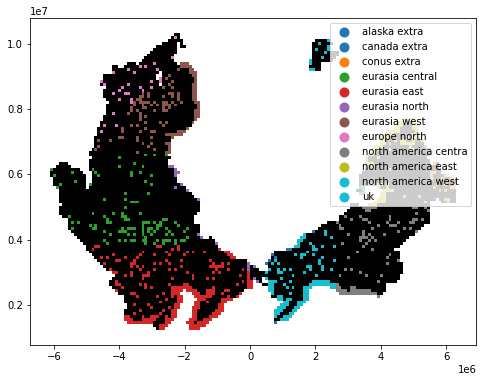

In [10]:
AGB_TILES_NEEDED = ExtractUtils.GET_TILES_NEEDED(DPS_DATA_TYPE = 'AGB', \
                                                tindex_master_fn = AGB_fall2022_noground_tindex_master_fn,\
                                                 bad_tiles = [], \
                                                boreal_tile_index_path = boreal_tile_index_path)

In [15]:
BAD_TILE_LIST = [3540,3634,3728,3823,3916,4004,41995,41807,41619]

# For the tindex_master, convert it into vector tiles that show the tiles we have
cols_list = ['tile_num','s3_path','local_path']

# Select the rows we have results for
tile_index_matches = boreal_tile_index.merge(tindex_master[~tindex_master['tile_num'].isin(BAD_TILE_LIST)][cols_list], how='right', on='tile_num')
tile_index_matches = tile_index_matches[tile_index_matches['s3_path'].notna()]
tile_index_matches.shape

(4714, 7)

In [16]:
# Testing overview resampling builds for COGs
if False:
    in_fn = '/projects/my-public-bucket/boreal_agb_202205041651623844_0042.tif'
    out_fn = '/projects/my-public-bucket/boreal_agb_202205041651623844_0042-TEST_GDAL_OVERVIEWS.tif'
    !gdal_translate -co OVERVIEW_RESAMPLING=AVERAGE -of COG $in_fn $out_fn 

# View s3 map layers

In [23]:
# Setup the mosaic tiling
tiler_base = "https://jqsd6bqdsf.execute-api.us-west-2.amazonaws.com/" #titiler.maap-project.org
tiler_mosaic =  "".join([tiler_base, "mosaicjson/tiles/{z}/{x}/{y}"])

In [12]:
# Fill in your favorite tile numbers that will highlight in red 
CHECK_TILE_LIST = [] #[3585,4108,1037,1549]
df = gpd.read_file('/projects/my-public-bucket/DPS_tile_lists/HLS_irregular_tiles.gpkg')
CHECK_TILE_LIST = df.tile_num.to_list()


DriverError: /projects/my-public-bucket/DPS_tile_lists/HLS_irregular_tiles.gpkg: No such file or directory

In [24]:
import importlib
import maplib_folium
importlib.reload(maplib_folium)

<module 'maplib_folium' from '/projects/icesat2_boreal/lib/maplib_folium.py'>

In [37]:
MAX_AGB = 125

AGB_local_layer = TileLayer(
            tiles= f"{tiler_mosaic}?url={AGB_mosaic_json_fn_local}&rescale=0,{MAX_AGB}&bidx=1&colormap_name=viridis",
            opacity=1,
            name="AGB fall 2023 Local",
            attr="MAAP",
            overlay=True
        )


AGB_50perc_layer = TileLayer(
            tiles= f"{tiler_mosaic}?url={AGB_mosaic_json_fn_50perc}&rescale=0,{MAX_AGB}&bidx=1&colormap_name=viridis",
            opacity=1,
            name="AGB fall 2023 50 perc",
            attr="MAAP",
            overlay=True
        )
#AGB_spring2022_tiles_layer = TileLayer(
#            tiles= f"{tiler_mosaic}?url={AGB_spring2022_mosaic_json_fn}&rescale=0,{MAX_AGB}&bidx=1&colormap_name=viridis",
#            opacity=1,
#            name="AGB spring 2022",
#            attr="MAAP",
#            overlay=True
#        )
#AGB_v2_tiles_layer = TileLayer(
#            tiles= f"{tiler_mosaic}?url={AGB_v2_mosaic_json_fn}&rescale=0,{MAX_AGB}&bidx=1&colormap_name=viridis",
#            opacity=1,
#            name="AGB v2 2022",
#            attr="MAAP",
#            overlay=True
#        )
#MAX_HT = 20
#Ht_tiles_layer  = TileLayer(
#            tiles= f"{tiler_mosaic}?url={Ht_mosaic_json_fn_noground}&rescale=0,{MAX_HT}&bidx=1&colormap_name=magma",
#            opacity=1,
#            name="Height 2020",
#            attr="MAAP",
#            overlay=True
#        )

maplib_folium.MAP_DPS_RESULTS(tiler_mosaic, 
                              #boreal_tile_index[~boreal_tile_index['tile_num'].isin(BAD_TILE_LIST)], #bad_tiles 
                              #geopandas.read_file( '/projects/my-public-bucket/analyze_agb/footprints_terrapulse-pub-data_boreal-tcc-unclipped-1995.gpkg'), # rm tiles [444, 576, 695, 805, 913,1127, 1197]
                              #tile_index_matches, 
                              #boreal_tile_index[boreal_tile_index['tile_num'].isin(CHECK_TILE_LIST)], 
                              #MATCH_TILES_NAME='AGB tiles',
                              #CHECK_TILES_NAME='Tiles to check',
                              mosaic_json_dict = 
                                  {     ######### PRODUCT LAYERS #######
                                        #---NASA ABoVE Aboveground Boreal Woody Biomass Density
                                        'agb_mosaic_json_s3_50perc_fn':       AGB_mosaic_json_fn_50perc, #AGB_fall2022_mosaic_json_fn,
                                        'agb_mosaic_json_s3_local_fn':       AGB_mosaic_json_fn_local, #AGB_fall2022_mosaic_json_fn,
                                        'topo_mosaic_json_s3_fn':      Topo_mosaic_json_fn,
                                        'mscomp_mosaic_json_s3_fn':    HLS_mosaic_c2020_json_fn,
                                        ######### ANALYSIS LAYERS ######
                                        'worldcover_json_s3_fn':       LC_mosaic_json_fn,  
                                        'tp_standage2020_json_s3_fn':  None,
                                        'tp_tcc2020_json_s3_fn':       None,
                                        'tp_tcc2020slope_json_s3_fn':  None,
                                        'tp_tcc2020pvalue_json_s3_fn': None, 
                                    },
                            max_AGB_display = MAX_AGB, max_AGBSE_display = 20,
                            map_width=1250, map_height=500,
                            mscomp_rgb_dict = None,
                            MS_BANDNAME = 'NBR2',
                            MS_BANDMIN=0.25,
                            MS_BANDMAX=0.45, #1.1,
                            MS_BANDNUM=13, #9,
                            MS_BANDCOLORBAR='nipy_spectral',
                            SHOW_WIDGETS=False
                            #ADD_TILELAYER = AGB_ground_tiles_layer  
                             )

TypeError: MAP_DPS_RESULTS() got an unexpected keyword argument 'MS_BANDNAME'

Sites to spot check: 

N 58.41332 E 7.25588  
- notice barren is showing high AGB  
- does masking out barren LC interfere with AGB prediction over actual barren that isnt class'd as such?  
- If this is the case - then we DONT want to remove BARREN prior to prediction - rather - just mask out after the fact - that way, small barren extents wont be horribly wrong due to near non-existant training

N 58.15207 E 6.85672

In [18]:
FOCAL_TILE = 11
m=maplib_folium.map_tile_atl08(FOCAL_TILE, tiler_mosaic, boreal_tile_index, ATL08_filt_tindex_master_fn = ATL08_filt_tindex_master_fn,
                             mosaic_json_dict = {'agb_mosaic_json_s3_fn': AGB_fall2022_mosaic_json_fn}, DO_NIGHT=False, map_width=1600, map_height=500, OVERVIEW_MAP=False,
                            max_AGB_display = 150, max_AGBSE_display = 20)
m

s3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/fall2022/ATL08_filt_tindex_master.csv


FileNotFoundError: maap-ops-workspace/shared/lduncanson/DPS_tile_lists/fall2022/ATL08_filt_tindex_master.csv

In [ ]:
MISSING_TILES = [3082, 2918, 40664, 2745,      # AK & NW Ca
                42809,                         # NE Sib Beringia
                1854, 1789, 1321, 36238, 1262, # Hudson Bay and Quebec
                1505, 1392, 34210, 33975,      # Southern edge,  mostly below 45N - might not have ATL08 processed
                37, 10, 148, 169, 446,         # Scand - 10 very little land so no ATL08?
                162, 629,                             # Western Russia
                27365,                                # Crimea
                1761,2651,2970,3417,3604, 4080        # Central and Eastern Siberia
                ]
print(MISSING_TILES)
len(MISSING_TILES)

In [ ]:
MISSING_TILES_for_redo = []
MISSING_ATL08 = []
MISSING_HLS = []
MISSING_Topo = []

ATL08_filt_tindex = pd.read_csv(ATL08_filt_tindex_master_fn, storage_options={'anon':True})
HLS_tindex = pd.read_csv(HLS_tindex_master_fn, storage_options={'anon':True})
Topo_tindex = pd.read_csv(Topo_tindex_master_fn, storage_options={'anon':True})

AGB_tindex = pd.read_csv(AGB_tindex_master_fn, storage_options={'anon':True})

for t in MISSING_TILES:

    if t in ATL08_filt_tindex.tile_num.to_list() and HLS_tindex.tile_num.to_list() and Topo_tindex.tile_num.to_list():
        MISSING_TILES_for_redo.append(t)
        
        # Just confirm that this tile is in fact not in the AGB tindex< if so, flag it with a print out.
        if t in AGB_tindex.tile_num.to_list():
            print(f"Tile {t} is in the AGB tindex, so maybe its not showing?")
    else:
        if t not in ATL08_filt_tindex.tile_num.to_list():
            MISSING_ATL08.append(t)
        if t not in HLS_tindex.tile_num.to_list():
            MISSING_HLS.append(t)
        if t not in Topo_tindex.tile_num.to_list():
            MISSING_Topo.append(t)
            
print(f"AGB does NOT exist for these {len(MISSING_TILES_for_redo)} tiles, but ATL08 filt, HLS, & Topo tiles do:\n{MISSING_TILES_for_redo}\nRe-do AGB run for these tiles.")

In [ ]:
MISSING_HLS

In [ ]:
MISSING_Topo